In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import pandas as pd

In [37]:
def calculate_variance_components(file_path):
    # First check if the file has a header
    with open(file_path, 'r') as f:
        first_line = f.readline().strip()

    # Check if first line contains column headers
    has_header = 'trait' in first_line and 'locus' in first_line

    # Read the data
    columns = ['trait', 'locus', 'add_eff', 'epi_loc', 'epi_eff', 'sfs']

    if has_header:
        # If file has headers, use them
        df = pd.read_csv(file_path, sep=r'\s+')
    else:
        # No headers, use our predefined column names
        df = pd.read_csv(file_path, sep=r'\s+', names=columns)

    # Convert columns to appropriate data types
    df['trait'] = pd.to_numeric(df['trait'], errors='coerce')
    df['locus'] = pd.to_numeric(df['locus'], errors='coerce')
    df['add_eff'] = pd.to_numeric(df['add_eff'], errors='coerce')
    df['epi_loc'] = pd.to_numeric(df['epi_loc'], errors='coerce')
    df['epi_eff'] = pd.to_numeric(df['epi_eff'], errors='coerce')
    df['sfs'] = pd.to_numeric(df['sfs'], errors='coerce')

    # Drop any rows with NaN values (which would come from conversion failures)
    df = df.dropna()

    # Initialize results dataframe
    results = []

    # Process each trait
    for trait_num in df['trait'].unique():
        trait_data = df[df['trait'] == trait_num]

        # Create a dictionary to store epistatic relationships
        epi_partners = {}
        for _, row in trait_data.iterrows():
            if row['epi_loc'] != 0:  # If this locus has an epistatic partner
                epi_partners[row['locus']] = row['epi_loc']

        # Calculate variance components for each locus in this trait
        for _, row in trait_data.iterrows():
            locus = row['locus']
            p = row['sfs']  # Allele frequency
            q = 1 - p       # Complementary allele frequency
            add_eff = row['add_eff']

            # Calculate additive variance component
            add_variance = p * q * (add_eff ** 2)

            # Initialize epistatic variance
            epi_variance = 0

            # Check if this locus is involved in epistatic interactions
            # Case 1: This locus is listed in epi_loc column of another locus
            partner_rows = trait_data[trait_data['epi_loc'] == locus]
            for _, partner_row in partner_rows.iterrows():
                partner_locus = partner_row['locus']
                partner_p = trait_data[trait_data['locus'] == partner_locus]['sfs'].values[0]
                partner_q = 1 - partner_p
                epi_effect = partner_row['epi_eff']
                # Half of the epistatic variance (shared with partner)
                epi_variance += 0.5 * p * q * partner_p * partner_q * (epi_effect ** 2)

            # Case 2: This locus references another locus in its epi_loc column
            if row['epi_loc'] != 0:
                partner_locus = row['epi_loc']
                # Find the partner locus in the dataframe
                partner_rows = trait_data[trait_data['locus'] == partner_locus]
                if not partner_rows.empty:
                    partner_p = partner_rows['sfs'].values[0]
                    partner_q = 1 - partner_p
                    epi_effect = row['epi_eff']
                    # Half of the epistatic variance (shared with partner)
                    epi_variance += 0.5 * p * q * partner_p * partner_q * (epi_effect ** 2)

            # Store results
            results.append({
                'trait': trait_num,
                'locus': locus,
                'sfs': p,  # Include the allele frequency in the results
                'add_variance': add_variance,
                'epi_variance': epi_variance,
                'total_variance': add_variance + epi_variance
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [38]:
vars = calculate_variance_components('alphasimr_output/test_sim_WF_1kbt_10000n_5000000bp_eff.txt')

In [39]:
vars.head(n=10)

,trait,locus,sfs,add_variance,epi_variance,total_variance
0,1,1.0,0.5168,0.000000,0.0,0.000000
1,1,2.0,0.5168,0.000000,0.0,0.000000
2,1,3.0,0.0016,0.000000,0.0,0.000000
3,1,4.0,0.4879,0.000000,0.0,0.000000
4,1,5.0,0.4879,0.000000,0.0,0.000000
5,1,6.0,0.5121,0.000000,0.0,0.000000
6,1,7.0,0.1720,0.000018,0.0,0.000018
7,1,8.0,0.3156,0.000000,0.0,0.000000
8,1,9.0,0.6839,0.000000,0.0,0.000000
9,1,10.0,0.3161,0.000529,0.0,0.000529


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline

def plot_binned_variance(vars, variance_col='add_variance', bin_width=0.05, output_filename=None):
    """
    Create a binned SFS vs total variance plot with 5 subplots for trait groups.

    Parameters:
    vars (DataFrame): DataFrame containing the variance data with columns 'trait', 'sfs', and variance column
    variance_col (str): Column name for variance to plot (default: 'add_variance')
    bin_width (float): Width of SFS bins (default: 0.05)
    output_filename (str): Optional filename to save the plot
    """
    # Create bins for SFS
    bins = np.arange(0, 1 + bin_width, bin_width)
    bin_centers = bins[:-1] + bin_width/2

    # Create figure with 5 subplots side by side
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
    fig.suptitle(f'SFS vs Total {variance_col.replace("_", " ").title()} by Trait Groups', fontsize=16)

    # Define colors for lines
    colors = plt.cm.tab10(np.linspace(0, 1, 5))

    # Group traits into sets of 5
    trait_groups = [
        list(range(1, 6)),    # Traits 1-5
        list(range(6, 11)),   # Traits 6-10
        list(range(11, 16)),  # Traits 11-15
        list(range(16, 21)),  # Traits 16-20
        list(range(21, 26))   # Traits 21-25
    ]

    # Loop through each group and create a subplot
    for i, trait_group in enumerate(trait_groups):
        ax = axes[i]
        ax.set_title(f'Traits {trait_group[0]}-{trait_group[-1]}')
        ax.set_xlabel('SFS (Allele Frequency)')

        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(f'Total {variance_col.replace("_", " ").title()}')

        # Plot each trait in the group
        for j, trait in enumerate(trait_group):
            # Filter data for this trait
            trait_data = vars[vars['trait'] == trait]

            # Skip if no data for this trait
            if trait_data.empty:
                continue

            # Create binned data for this trait
            binned_data = []
            for bin_idx in range(len(bins) - 1):
                bin_start, bin_end = bins[bin_idx], bins[bin_idx + 1]

                # Get data points in this bin
                mask = (trait_data['sfs'] >= bin_start) & (trait_data['sfs'] < bin_end)
                bin_data = trait_data[mask]

                # Calculate total variance in this bin
                total_variance = bin_data[variance_col].sum()

                binned_data.append({
                    'bin_center': bin_centers[bin_idx],
                    'total_variance': total_variance,
                    'count': len(bin_data)
                })

            # Convert to DataFrame
            binned_df = pd.DataFrame(binned_data)

            # Plot bar chart with width proportional to bin_width
            ax.bar(binned_df['bin_center'], binned_df['total_variance'],
                  width=bin_width*0.8, alpha=0.7, color=colors[j],
                  label=f'Trait {trait}')

            # Add line connecting bin centers for trend visualization
            ax.plot(binned_df['bin_center'], binned_df['total_variance'],
                   '-', color=colors[j], lw=2)

        # Add legend
        ax.legend(fontsize='small')

        # Set x-axis from 0 to 1 (full range of possible SFS values)
        ax.set_xlim(0, 1)

        # Add grid for easier reading
        ax.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')

    plt.show()

    return fig, axes

def plot_per_locus_variance(vars, variance_col='add_variance', output_filename=None):
    """
    Create a scatter plot of SFS vs. variance per locus with fitted splines,
    with 5 subplots for trait groups.

    Parameters:
    vars (DataFrame): DataFrame containing the variance data with columns 'trait', 'sfs', and variance column
    variance_col (str): Column name for variance to plot (default: 'add_variance')
    output_filename (str): Optional filename to save the plot
    """
    # Create figure with 5 subplots side by side
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
    fig.suptitle(f'SFS vs {variance_col.replace("_", " ").title()} by Trait Groups', fontsize=16)

    # Define colors for lines
    colors = plt.cm.tab10(np.linspace(0, 1, 5))

    # Group traits into sets of 5
    trait_groups = [
        list(range(1, 6)),    # Traits 1-5
        list(range(6, 11)),   # Traits 6-10
        list(range(11, 16)),  # Traits 11-15
        list(range(16, 21)),  # Traits 16-20
        list(range(21, 26))   # Traits 21-25
    ]

    # Loop through each group and create a subplot
    for i, trait_group in enumerate(trait_groups):
        ax = axes[i]
        ax.set_title(f'Traits {trait_group[0]}-{trait_group[-1]}')
        ax.set_xlabel('SFS (Allele Frequency)')

        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(f'{variance_col.replace("_", " ").title()}')

        # Plot each trait in the group
        for j, trait in enumerate(trait_group):
            # Filter data for this trait
            trait_data = vars[vars['trait'] == trait]

            # Skip if no data for this trait
            if trait_data.empty:
                continue

            # Plot scatter points
            ax.scatter(trait_data['sfs'], trait_data[variance_col],
                      alpha=0.5, color=colors[j], label=f'Trait {trait}')

            # Only fit spline if we have enough points (more than 3) with non-zero variance
            valid_data = trait_data[(trait_data[variance_col] > 0) & (trait_data['sfs'] > 0)]
            if len(valid_data) > 3:
                # Sort by SFS for spline fitting
                sorted_data = valid_data.sort_values('sfs')
                x = sorted_data['sfs'].values
                y = sorted_data[variance_col].values

                # Create a smoother x array for the spline curve
                x_smooth = np.linspace(min(x), max(x), 100)

                # Fit spline with appropriate smoothing factor
                # Lower s means less smoothing
                try:
                    spline = UnivariateSpline(x, y, s=len(x) * 0.1)
                    y_smooth = spline(x_smooth)
                    ax.plot(x_smooth, y_smooth, '-', color=colors[j], lw=2)
                except:
                    # If spline fitting fails, use simpler approach
                    ax.plot(x, y, '-', color=colors[j], lw=1)

        # Add legend
        ax.legend(fontsize='small')

        # Use log scale if range of values is large
        if vars[variance_col].max() / (vars[variance_col].replace(0, np.nan).min() or 1e-10) > 100:
            ax.set_yscale('log')

        # Set x-axis from 0 to 1 (full range of possible SFS values)
        ax.set_xlim(0, 1)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')

    plt.show()

    return fig, axes


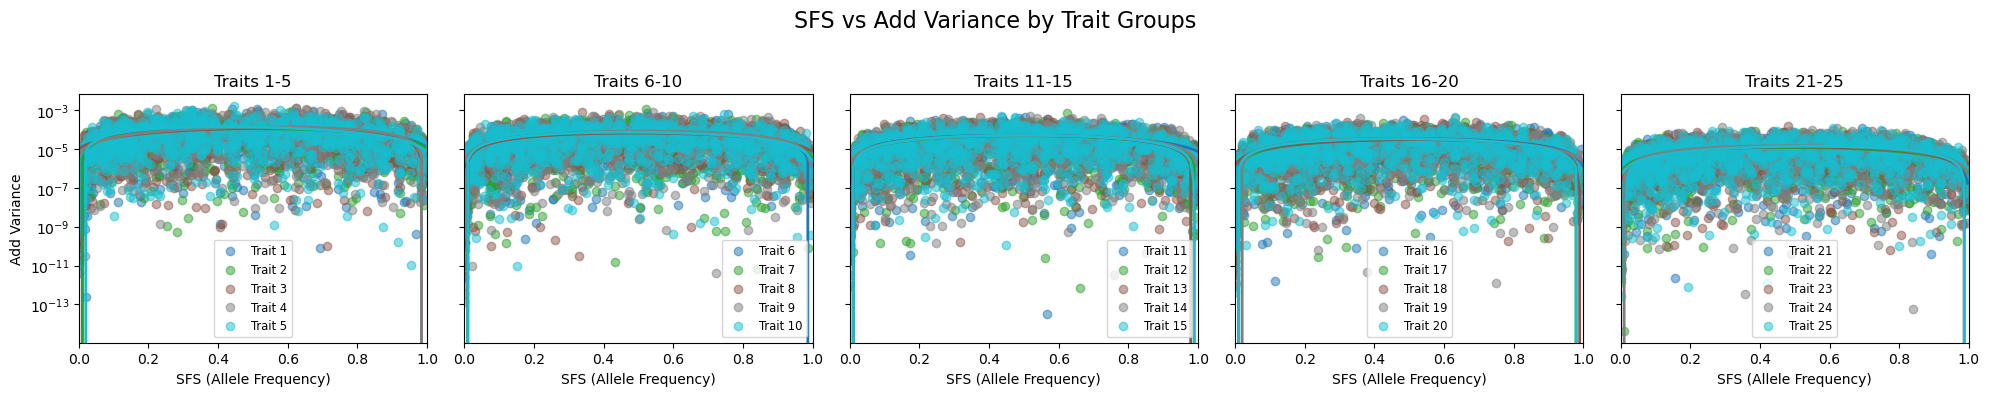

/tmp/ipykernel_2074904/2929102540.py:177: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


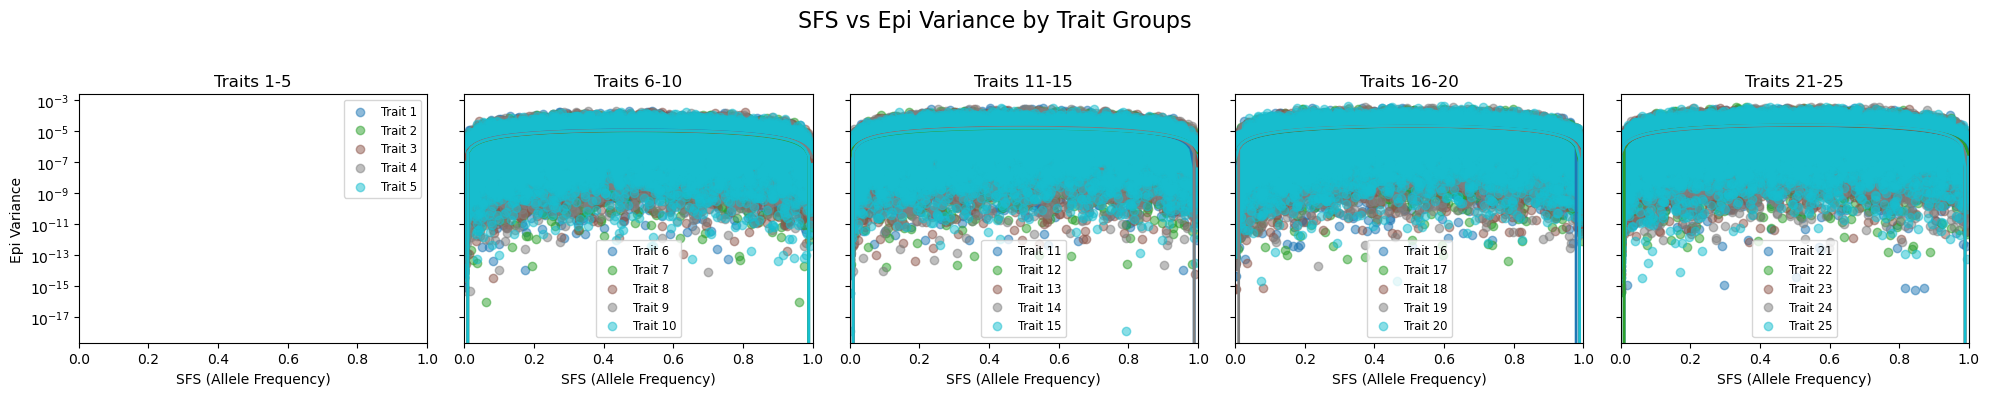

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Traits 1-5'}, xlabel='SFS (Allele Frequency)', ylabel='Epi Variance'>,
        <Axes: title={'center': 'Traits 6-10'}, xlabel='SFS (Allele Frequency)'>,
        <Axes: title={'center': 'Traits 11-15'}, xlabel='SFS (Allele Frequency)'>,
        <Axes: title={'center': 'Traits 16-20'}, xlabel='SFS (Allele Frequency)'>,
        <Axes: title={'center': 'Traits 21-25'}, xlabel='SFS (Allele Frequency)'>],
       dtype=object))

In [41]:
plot_per_locus_variance(vars, variance_col='add_variance')
plot_per_locus_variance(vars, variance_col='epi_variance')

In [42]:
def plot_binned_variance(df, bin_width=0.05, variance_col='add_variance', output_filename=None):
    """
    Create plots of binned SFS vs total variance, with separate subplot for each trait group.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing trait, locus, sfs, and variance columns
    bin_width : float
        Width of each SFS bin (default: 0.05)
    variance_col : str
        Column name for the variance to plot (default: 'add_variance')
    output_filename : str, optional
        If provided, save the figure to this filename
    """
    # Create bins for SFS
    bins = np.arange(0, 1 + bin_width, bin_width)
    bin_centers = bins[:-1] + bin_width/2

    # Create figure with 5 subplots side by side
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
    fig.suptitle(f'Binned SFS vs Total {variance_col.replace("_", " ").title()} by Trait Groups', fontsize=16)

    # Define colors for lines
    colors = plt.cm.tab10(np.linspace(0, 1, 5))

    # Group traits into sets of 5
    max_trait = df['trait'].max()
    trait_groups = []
    for i in range(1, max_trait + 1, 5):
        trait_groups.append(list(range(i, min(i+5, max_trait+1))))

    # If we have more than 5 groups, only use the first 5
    trait_groups = trait_groups[:5]

    # Loop through each group and create a subplot
    for i, trait_group in enumerate(trait_groups):
        ax = axes[i]
        ax.set_title(f'Traits {trait_group[0]}-{trait_group[-1]}')
        ax.set_xlabel('SFS (Allele Frequency)')

        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(f'Total {variance_col.replace("_", " ").title()}')

        # Plot each trait in the group
        for j, trait in enumerate(trait_group):
            # Filter data for this trait
            trait_data = df[df['trait'] == trait]

            # Skip if no data for this trait
            if trait_data.empty:
                continue

            # Create binned data for this trait
            binned_data = []
            for bin_idx in range(len(bins) - 1):
                bin_start, bin_end = bins[bin_idx], bins[bin_idx + 1]

                # Get data points in this bin
                mask = (trait_data['sfs'] >= bin_start) & (trait_data['sfs'] < bin_end)
                bin_data = trait_data[mask]

                # Calculate total variance in this bin
                total_variance = bin_data[variance_col].sum()

                binned_data.append({
                    'bin_center': bin_centers[bin_idx],
                    'total_variance': total_variance,
                    'count': len(bin_data)
                })

            # Convert to DataFrame
            binned_df = pd.DataFrame(binned_data)

            # Plot bar chart with width proportional to bin_width
            ax.bar(binned_df['bin_center'], binned_df['total_variance'],
                  width=bin_width*0.8, alpha=0.7, color=colors[j],
                  label=f'Trait {trait}')

            # Add line connecting bin centers for trend visualization
            ax.plot(binned_df['bin_center'], binned_df['total_variance'],
                   '-', color=colors[j], lw=2)

        # Add legend
        ax.legend(fontsize='small')

        # Set x-axis from 0 to 1 (full range of possible SFS values)
        ax.set_xlim(0, 1)

        # Add grid for easier reading
        ax.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')

    plt.show()

    return fig, axes

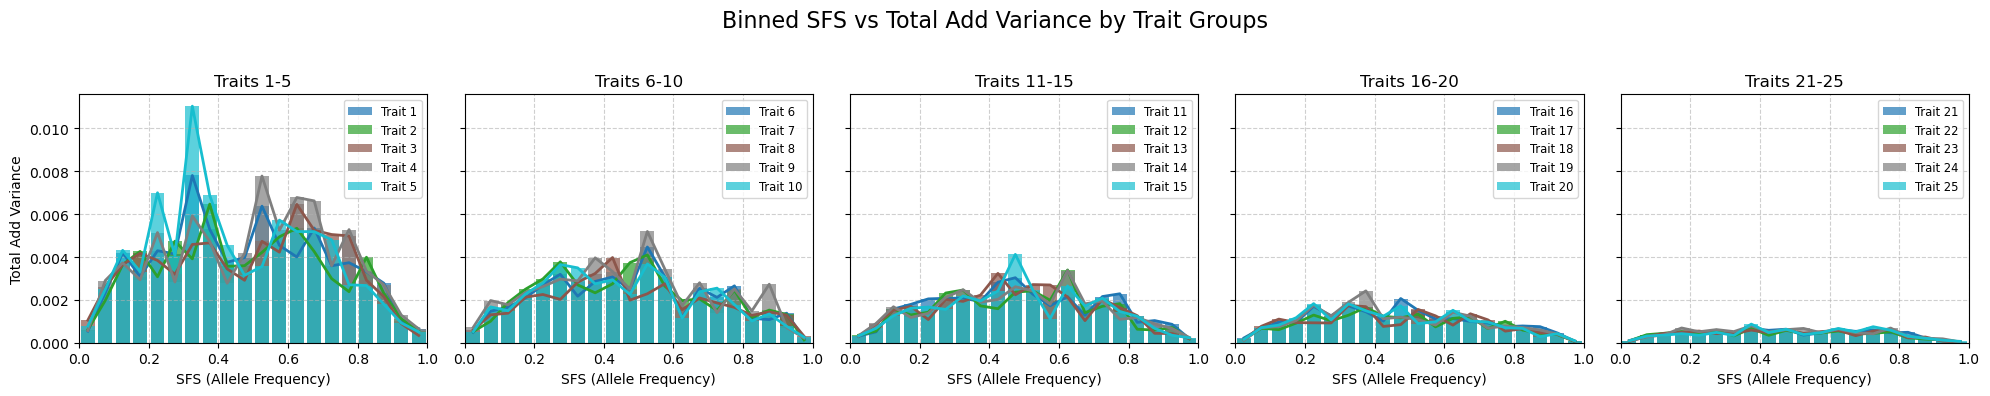

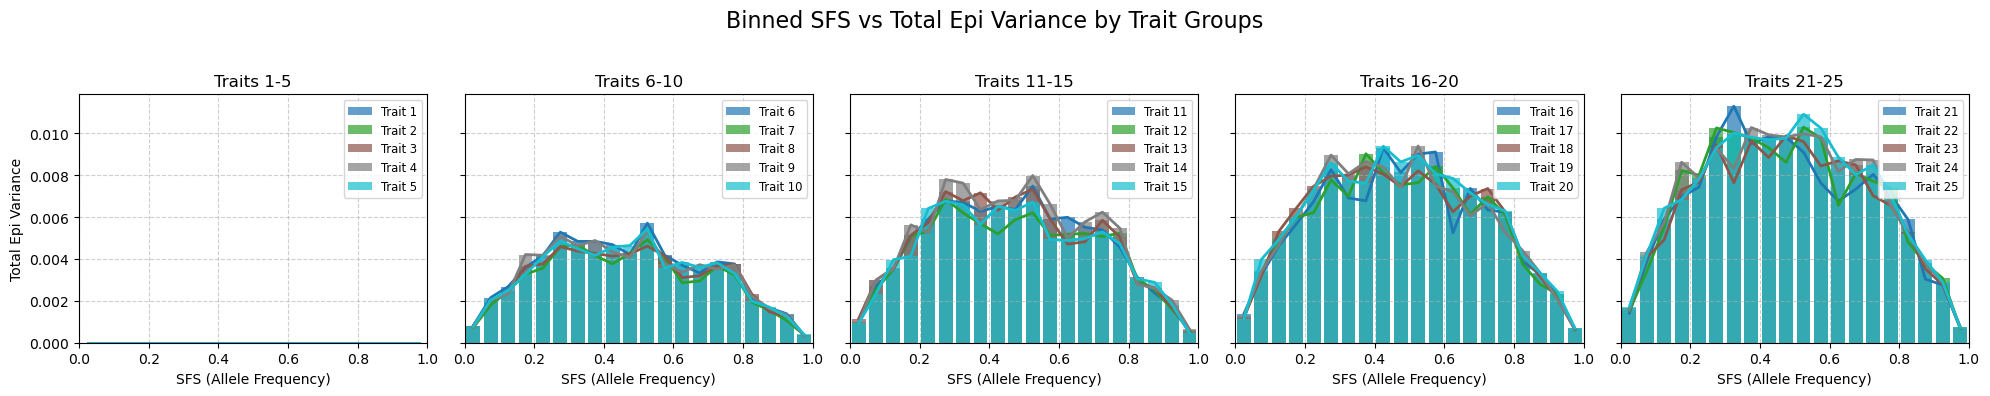

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Traits 1-5'}, xlabel='SFS (Allele Frequency)', ylabel='Total Epi Variance'>,
        <Axes: title={'center': 'Traits 6-10'}, xlabel='SFS (Allele Frequency)'>,
        <Axes: title={'center': 'Traits 11-15'}, xlabel='SFS (Allele Frequency)'>,
        <Axes: title={'center': 'Traits 16-20'}, xlabel='SFS (Allele Frequency)'>,
        <Axes: title={'center': 'Traits 21-25'}, xlabel='SFS (Allele Frequency)'>],
       dtype=object))

In [43]:
plot_binned_variance(vars, bin_width=0.05, variance_col='add_variance')
plot_binned_variance(vars, bin_width=0.05, variance_col='epi_variance')
